# Convert pdf to markdown

In [73]:
import os
from docling.datamodel.base_models import InputFormat
from docling.datamodel.pipeline_options import PdfPipelineOptions
from docling.document_converter import DocumentConverter, PdfFormatOption
from dotenv import load_dotenv

load_dotenv()

IMAGE_RESOLUTION_SCALE = 2
pipeline_options = PdfPipelineOptions()
pipeline_options.images_scale = IMAGE_RESOLUTION_SCALE
pipeline_options.generate_page_images = True
pipeline_options.do_ocr = False
pipeline_options.create_legacy_output = False


converter = DocumentConverter(format_options={InputFormat.PDF: PdfFormatOption(pipeline_options=pipeline_options)})

In [74]:
from docling.document_converter import DocumentConverter
from pathlib import Path

pdf_path = Path("docs/coercive.pdf")
file_name = pdf_path.stem


document = converter.convert(pdf_path)
md_text = document.document.export_to_markdown()
with open(f"docs/{file_name}.md", "w", encoding="utf-8") as f:
    f.write(md_text)


Fetching 9 files: 100%|██████████| 9/9 [00:00<00:00, 86579.67it/s]


In [88]:
from langchain_text_splitters import ExperimentalMarkdownSyntaxTextSplitter

headers_to_split_on = [("#", "Title"), ("##", "Section")]

splitter = ExperimentalMarkdownSyntaxTextSplitter(headers_to_split_on)
md_header_splits = splitter.split_text(md_text)
md_header_splits


[Document(metadata={'Section': 'Can we justify eliminating coercive measures in psychiatry?'}, page_content='\nE J D Prinsen, 1 J J M van Delden 2\n\n'),
 Document(metadata={'Section': 'ABSTRACT'}, page_content='\nThe practice of coercive measures in psychiatry is controversial. Although some have suggested that it may be acceptable if patients are a danger to others or to themselves, others committed themselves to eliminate it. Ethical, legal and clinical considerations become more complex when the mental incapacity is temporary and when the coercive measures serve to restore autonomy. We discuss these issues, addressing the conflict between autonomy and beneficence/non-maleficence, human dignity, the experiences of patients and the effects of coercive measures. We argue that an appeal to respect autonomy and/or human dignity cannot be a sufficient reason to reject coercive measures. All together, these ethical aspects can be used both to support and to reject a non-seclusion approach

## Remove sections after references

In [43]:
# Find the splits between ABSTRACT and REFERENCES
# Find the splits between ABSTRACT and REFERENCES
abstract_index = next(
    i for i, split in enumerate(md_header_splits) if split.metadata.get("Section").lower() == "abstract"
)

# Extract only the splits between ABSTRACT and REFERENCES


reference_index = next(
    i for i, split in enumerate(md_header_splits) if split.metadata.get("Section").lower() == "references"
)

# Extract only the splits before this split
md_header_splits_between_abstract_and_references = md_header_splits[(abstract_index + 1) : reference_index]


In [44]:
md_header_splits_between_abstract_and_references

[Document(metadata={'Section': 'Definition and prevalence'}, page_content="There are a number of definitions for seclusion in the international literature. Lendemeijer has formulated the following definition after reviewing the literature on seclusion in psychiatry: ''Locking a patient alone in a room for protection of the patient and his environment and in order to control problem behaviour and to enable nursing and treatment''. 7 Patients can voluntarily choose to be secluded, however this paper will address involuntarily use of seclusion. The definition above implies that seclusion itself is not a form of treatment but an intervention to make treatment possible. Some people even see the use of seclusion and restraint as treatment failure. 11 12 Some articles do, however, describe therapeutic effects of seclusion; patients become calm and gain access to repressed memories during seclusion due to decreased stimulation from sensory overload. Also it has been described that seclusion pr

## Extract title, authors, affilication from the first page

In [23]:
import base64
from io import BytesIO

# Extract the first page of the PDF
first_page_image = document.document.pages[1].image.pil_image

# Encode the image in base64
buffered = BytesIO()
first_page_image.save(buffered, format="PNG")
img_str = base64.b64encode(buffered.getvalue()).decode("utf-8")


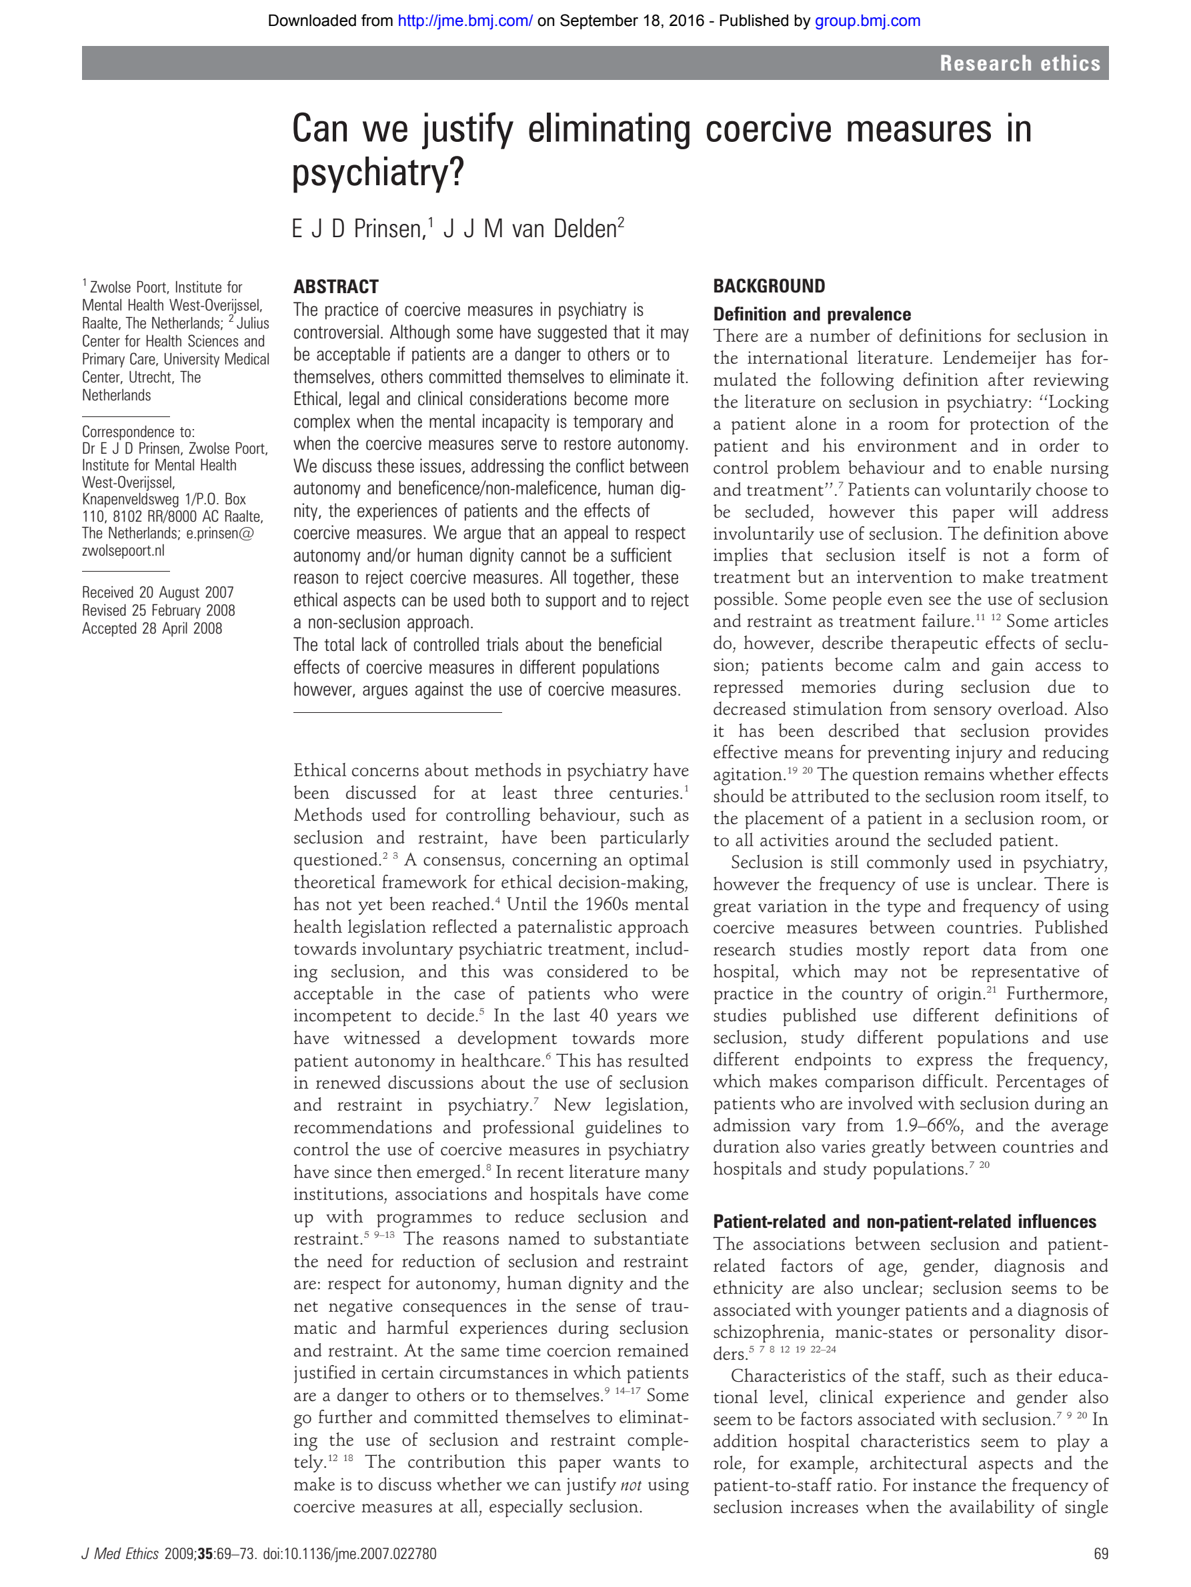

In [24]:
first_page_image

In [32]:
import ollama

response = ollama.chat(
    model="llama3.2-vision",
    messages=[
        {
            "role": "user",
            "content": """The image is a first page of an academic article.
        Extract the title, authors, and affiliation of the first author from the image.
        Output should be a JSON object in this format - {"title": <Title>, "authors": [<Authors>], "affiliation": <Affiliation>}  .
        Do not output anything else""",
            "images": [img_str],
        }
    ],
)

answer = response.get("message", {}).get("content", "").strip()


In [33]:
answer

'{"title": "Can we justify eliminating coercive measures in psychiatry?", "authors": ["E J D Prinsen", "J J M van Delden"], "affiliation": "Institute for Mental Health, West-Overijssel, Zwolle, The Netherlands"}'

In [35]:
md_header_splits_before_references

[Document(metadata={'Section': 'Can we justify eliminating coercive measures in psychiatry?'}, page_content='## Can we justify eliminating coercive measures in psychiatry?  \nE J D Prinsen, 1 J J M van Delden 2'),
 Document(metadata={'Section': 'ABSTRACT'}, page_content='## ABSTRACT  \nThe practice of coercive measures in psychiatry is controversial. Although some have suggested that it may be acceptable if patients are a danger to others or to themselves, others committed themselves to eliminate it. Ethical, legal and clinical considerations become more complex when the mental incapacity is temporary and when the coercive measures serve to restore autonomy. We discuss these issues, addressing the conflict between autonomy and beneficence/non-maleficence, human dignity, the experiences of patients and the effects of coercive measures. We argue that an appeal to respect autonomy and/or human dignity cannot be a sufficient reason to reject coercive measures. All together, these ethical a

# Get summary

In [50]:
import toml

with open("prompts/prompts.toml", "r") as f:
    prompts = toml.load(f)

essentials_prompt = prompts["extract_essentials"]["prompt"]
section_summary_prompt = prompts["extract_summary"]["prompt"]


In [55]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

llm_model = ChatOpenAI(model="grok-beta", base_url="https://api.x.ai/v1", api_key=os.getenv("XAI_API_KEY"))

summary_prompt = ChatPromptTemplate.from_messages([
    ("system", section_summary_prompt),
    ("user", "{text}"),
])

extract_essentials_prompt = ChatPromptTemplate.from_messages([
    ("system", essentials_prompt),
    ("user", "{text}"),
])


context_text = "\n\n".join([split.page_content for split in md_header_splits_before_references])


summary_chain = summary_prompt | llm_model | StrOutputParser()
extract_essentials_chain = extract_essentials_prompt | llm_model | StrOutputParser()
essentials = extract_essentials_chain.invoke({"text": context_text})

summaries = []

for split in md_header_splits_between_abstract_and_references:
    if len(split.page_content) > 100:
        summary = summary_chain.invoke({"text": split.page_content})
        output = {"section_header": split.metadata.get("Section"), "summary": summary}
        summaries.append(output)

summaries


[{'section_header': 'Definition and prevalence',
  'summary': '**Seclusion in psychiatry**, as defined by Lendemeijer, involves **locking a patient alone in a room** to control problem behavior, protect the patient and others, and facilitate treatment. While some view seclusion as a **treatment failure**, others note therapeutic benefits like calming effects and access to repressed memories due to reduced sensory input. However, the effectiveness of seclusion remains under debate, with questions about whether benefits are from the seclusion itself or related activities. **Usage varies widely internationally**, with reported seclusion rates ranging from 1.9% to 66% of admissions, influenced by differing definitions, study populations, and endpoints, making **global comparisons challenging**.'},
 {'section_header': 'Patient-related and non-patient-related influences',
  'summary': '**Seclusion in psychiatric settings** is influenced by a variety of patient-related factors including **age

In [57]:
from IPython.display import Markdown

Markdown(essentials)


### Catchy Summary:
Seclusion in psychiatry: ethical dilemma or necessary intervention?

### TL;DR:
Seclusion in psychiatric care remains a contentious issue, balancing between patient autonomy and safety. **Ethical debates have intensified over the last 40 years**, focusing on the conflict between respecting autonomy and the potential benefits of coercive measures like seclusion. This paper examines whether seclusion can be justified ethically, considering its impact on patient autonomy, dignity, and safety. **The authors argue that while seclusion can be seen as a violation of autonomy, it might also be necessary to restore autonomy in some cases.** However, the lack of empirical evidence on the effectiveness of seclusion, coupled with reports of negative psychological and physical effects, suggests a need for more research. 

### Key Takeaways:
1. **Ethical Complexity:** The use of seclusion in psychiatry involves a complex interplay of ethical principles like autonomy, beneficence, and human dignity.
  
2. **Lack of Evidence:** There is a significant absence of controlled trials evaluating the effectiveness of seclusion, making it difficult to justify its use solely on potential benefits.

3. **Reduction Programs:** While efforts to reduce or eliminate seclusion have shown some success, complete elimination remains elusive due to extreme cases where coercive measures are deemed necessary.

### Importance to Researchers:
This paper **highlights the ethical and practical dilemmas in psychiatric care**, urging researchers to conduct controlled trials to assess the true benefits and harms of seclusion. It underscores the **need for evidence-based practice** in psychiatry, which can influence future policy, legislation, and clinical guidelines on coercive measures.

In [60]:
summary_text = "\n\n".join([f"## {summary['section_header']}\n{summary['summary']}" for summary in summaries])

Markdown(summary_text)


## Definition and prevalence
**Seclusion in psychiatry**, as defined by Lendemeijer, involves **locking a patient alone in a room** to control problem behavior, protect the patient and others, and facilitate treatment. While some view seclusion as a **treatment failure**, others note therapeutic benefits like calming effects and access to repressed memories due to reduced sensory input. However, the effectiveness of seclusion remains under debate, with questions about whether benefits are from the seclusion itself or related activities. **Usage varies widely internationally**, with reported seclusion rates ranging from 1.9% to 66% of admissions, influenced by differing definitions, study populations, and endpoints, making **global comparisons challenging**.

## Patient-related and non-patient-related influences
**Seclusion in psychiatric settings** is influenced by a variety of patient-related factors including **age, gender, diagnosis, and ethnicity**. Younger patients and those diagnosed with schizophrenia, manic-states, or personality disorders are more likely to experience seclusion. **Staff characteristics** also play a crucial role; their educational background, clinical experience, and gender impact seclusion practices. Additionally, **hospital characteristics** like architectural design and patient-to-staff ratios significantly affect the frequency of seclusion. A lower staff ratio often correlates with increased seclusion practices. These insights suggest that a multifaceted approach considering patient demographics, staff attributes, and facility design is necessary to manage and potentially reduce the use of seclusion in mental health care settings.

## Research ethics
The section titled **"$section_header"** discusses the complex factors influencing the decision to use seclusion in psychiatric care settings. **Key points** include:

- **Reduction Strategies**: Staff and patient education, environmental modifications, effective communication, and administrative changes are critical in reducing seclusion and restraint, as noted by Taxis.

- **Decision-Making**: The choice to seclude is influenced by the decision-maker's personal history, moral conscience, institutional culture, legal frameworks, past decisions, and the opinions of peers and superiors.

- **Cultural Shift**: A shift in institutional culture is deemed essential for decreasing the reliance on seclusion.

- **Debate on Non-Seclusion**: The multifaceted nature of seclusion decisions sparks debate on whether a total non-seclusion policy is feasible or justifiable, highlighting the need for further discussion on this approach.

This section emphasizes the need for a holistic approach in psychiatric care, focusing not only on patient behavior but also on the intricate interplay of caregiver psychology and institutional dynamics.

## ETHICAL ISSUES
The section titled **'Respect for Autonomy vs. Human Dignity'** discusses the ethical dilemma in psychiatric care regarding the use of seclusion. **Respect for autonomy** suggests that patients should have control over their treatment, thereby opposing seclusion. However, **seclusion is often justified** by the need to **protect patients from harm** and to foster a **therapeutic environment**, which might sometimes require limiting autonomy to ensure safety and dignity. This creates a complex balance where the immediate benefits of seclusion must be weighed against the potential violation of patient rights and dignity.

## Autonomy
**The section on autonomy in medical ethics** delves into the debate surrounding the prioritization of **autonomy** in healthcare, particularly in psychiatry. It outlines three main criticisms of autonomy as the central ethical principle. Firstly, autonomy must be balanced with other ethical considerations like beneficence, as argued by Beauchamp & Childress. Secondly, autonomy is not an isolated concept but is inherently **relational**, suggesting that individual autonomy develops through interactions with others. Thirdly, Campbell posits that **dependency** can be more fundamental than autonomy, highlighting that autonomous behavior can coexist with dependency. This perspective challenges the traditional view of autonomy as self-sufficiency, advocating for **compassionate interference** where interventions might be necessary to foster autonomy, even if they appear coercive. This nuanced understanding of autonomy suggests that seclusion in psychiatric care might not always be an infringement on autonomy but could be a means to achieve it, thus complicating the ethical landscape of patient care.

## Human dignity
**Human dignity**, a central concept in moral discussions, is often invoked in debates over seclusion in medical settings. It encompasses **inherent dignity**, an unchangeable moral quality, and **individualistic dignity**, which can fluctuate based on personal and social conditions. Seclusion practices often infringe on the former by not respecting this inherent value, though the impact on individualistic dignity remains less clear. **Nordenfelt** describes dignity as tied to one's identity and autonomy, linked to self-respect and worth. Despite seclusion's intended therapeutic goals—to prevent harm, manage behavior, and aid treatment—**there is no solid evidence** supporting its efficacy or safety. **Negative effects** like physical and psychological harm have been documented, but without controlled trials, the true impact remains uncertain. The lack of evidence should push for alternative strategies to manage extreme behaviors in healthcare settings, ensuring practices align with the ethical standards of respecting human dignity.

## DISCUSSION
The section titled **'Respect for Autonomy and Human Dignity in Seclusion Practices'** delves into the complex interplay between ethical principles and the practice of seclusion in healthcare settings. Initially, the assumption was that autonomy and dignity would inherently oppose seclusion. However, **the discussion reveals that these ethical concepts are ambiguous and can support seclusion under certain conditions**. Coercion, while seemingly voiding autonomy, might be necessary for some patients to achieve or regain autonomy. Similarly, **dignity, often seen as individualistic, can be interpreted differently**; while seclusion might infringe upon personal identity and thus dignity, it could also be argued that in some contexts, seclusion aids in restoring dignity by reducing shame and fostering understanding and respect from healthcare staff. The ambiguity in these ethical concepts implies that an appeal to respect for autonomy or dignity alone isn't sufficient to outright reject seclusion. Instead, **the focus shifts to how seclusion is practiced**, emphasizing the need for it to be done in a manner that respects patient dignity, potentially making seclusion a viable option when handled with care and understanding.

## Experiences of patients
The section titled **"$section_header"** discusses **patient experiences with seclusion**, highlighting both **negative and positive aspects**. **Negative experiences** are predominant, often linked to a **lack of understanding** about the reasons for seclusion and **insufficient opportunities** for dialogue. **Education and information** about seclusion are critical, as patients feel more violated when not properly informed. Despite these negatives, **some patients acknowledge benefits** from seclusion, though perceptions vary significantly between **patients and nursing staff**; only 4% of patients compared to 60% of nurses see it as often beneficial. This discrepancy indicates a need for **individualised treatment plans** that involve regular discussions and revisions with patients by qualified staff. The debate seems to focus more on **how** seclusion is applied rather than its **ethical justification**, with only a minority advocating for its complete elimination.

## Effects of seclusion; promoting wellbeing
### **Seclusion in Psychiatric Care**

**Seclusion** is a practice within psychiatric care where a patient is **isolated in a room** for the safety of both themselves and others. This intervention is **not used as a punishment** but rather as a protective measure to prevent harm. Key points include:

- **Purpose**: To ensure safety by preventing potential harm to the patient or others.
- **Ethical Considerations**: Must be used judiciously, respecting patient rights and dignity.
- **Regulation**: Guidelines and protocols dictate its use, emphasizing it as a last resort after other interventions have failed. 

This approach underscores the **complex balance** between safety and patient autonomy, highlighting the need for careful monitoring and ethical oversight.

## Research ethics
**Seclusion in psychiatric care** has both critics and proponents. Despite its **deleterious effects**, only 22% of secluded patients support its total elimination, indicating its perceived necessity in extreme situations. Studies show varied success in reducing seclusion; some report significant decreases, but this often comes with increased patient assaults. **No definitive data** exists on the best combination of seclusion, restraint, or medication, leading to debates on the ethics of forced medication versus seclusion. The latter can provide diagnostic insights not possible with tranquilized patients. The **Council of Europe** allows for mechanical restraint in exceptional cases, emphasizing the use of the least restrictive methods, yet there's no consensus on what these are. This highlights a **critical need for research** to guide clinical practices towards minimizing coercion while ensuring safety.

## CONCLUSION
The section titled **'Seclusion and Coercive Measures in Psychiatry'** delves into the ethical and practical considerations surrounding the use of seclusion in psychiatric care. **Key points** include:

- **Ethical Justifications**: The argument posits that respect for autonomy and human dignity alone cannot conclusively support or oppose seclusion. These principles can be interpreted in ways that either support or reject the use of seclusion.

- **Practical Limitations**: Despite reduction programs, **coercive measures like seclusion are still sometimes deemed necessary** to manage extreme behaviors where safety is at risk.

- **Lack of Evidence**: There is a **critical gap in research** regarding the effects of seclusion. The absence of controlled trials means that seclusion's effectiveness and appropriateness remain unproven.

- **Call for Research**: The paper advocates for **randomized controlled trials** to assess seclusion's benefits against other interventions, emphasizing that without evidence of positive outcomes, the principle of "first, do no harm" should guide practices.

- **Ethical and Practical Synthesis**: The argument concludes that neither ethical grounds alone nor the absence of alternatives can justify seclusion without **empirical evidence** of its benefits, highlighting the need for further research to inform policy and practice.

In [59]:
summaries[0]

{'section_header': 'Definition and prevalence',
 'summary': '**Seclusion in psychiatry**, as defined by Lendemeijer, involves **locking a patient alone in a room** to control problem behavior, protect the patient and others, and facilitate treatment. While some view seclusion as a **treatment failure**, others note therapeutic benefits like calming effects and access to repressed memories due to reduced sensory input. However, the effectiveness of seclusion remains under debate, with questions about whether benefits are from the seclusion itself or related activities. **Usage varies widely internationally**, with reported seclusion rates ranging from 1.9% to 66% of admissions, influenced by differing definitions, study populations, and endpoints, making **global comparisons challenging**.'}